# Plan

## Analysis ideas

* Rolling correlations of individual features against forward returns. Try for 1 week ahead and 2 weeks ahead.
* Correlations:
    * Subregional imbalance
    * Rolling window (EW)MA of injection/withdrawal
    * Current storage levels

## Model ideas

* Rolling 1 week regression group by season.

# Load Data 

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar

from data_cleaning import read_gas_data, create_feature_df


def rolling_correlation(df1, df2, window_size=30):
    rolling_correlations = pd.DataFrame(index=df1.index[window_size:], columns=df1.columns)
    for col in df1.columns:
        rolling_correlations[col] = df1[col].rolling(window=window_size).corr(df2[col])
        
    return rolling_correlations



sns.set_style('darkgrid')
file_path = fr'raw/USGasData.xlsx'
tabs = ['Storage', 'Production', 'Demand-Actual', 'Demand-Normal', 'Prices-Cash', 'Prices-Cash Basis']
pickle_files = ['storage.pkl', 'production.pkl', 'demand_actual.pkl', 'demand_normal.pkl', 'prices.pkl', 'basis.pkl']
cap = 20
cap_prices = True
read_pickle = False

S, PD, DA, DN, P, B = read_gas_data(file_path, cap_prices=cap_prices, cap=cap, read_pickle=True)
F = create_feature_df(S, PD, DA, DN, actual=True)
mask = F.columns.get_level_values(1).str.endswith('Sto')
DS = F.loc[:, ~mask].iloc[:-7].pct_change().mul(-1)
HH = P.iloc[:,-1]
R = P.iloc[:,:-1].pct_change(7).shift(-1).clip(-3,7).dropna()



def plotcorr(F, P, forward_period, window, monthly=False):
    """
    forward_period - the number of periods to calculate forward returns. The forecast horizon
    window - Rolling window ma length to calculate moving average of percentage returns of SD. If very high, means demand is going up in the past few days.
    
    """
    # seasons
    seasonal_months = [[12, 1, 2], [3,4,5], [6,7,8], [9,10,11]]
    seasons = ['WIN', 'SUM', 'SPR', 'AUT']
    months = [calendar.month_abbr[i] for i in range(1, 13)]
    months_number = [i for i in range(1,13)]
    
    # only take demand-supply
    mask = F.columns.get_level_values(1).str.endswith('Sto')
    
    # create corr df
    idx = F.loc[:,~mask].columns
    corr_df = pd.DataFrame(index=idx)
    
    # calculate SD returns
    SD = F.loc[:, ~mask].iloc[:-forward_period].pct_change().mul(-1)
    
    # calculate spot returns
    R = P.iloc[:,:-1].pct_change(forward_period).shift(-1).clip(-10,10).dropna()
    
    # loop
    if monthly==False:
        for i, season in enumerate(seasons):

            season_SD = SD.loc[SD.index.month.isin(seasonal_months[i])]
            season_R = R.loc[R.index.month.isin(seasonal_months[i])]

            corr = season_SD.rolling(window).mean().corrwith(season_R).dropna()
            corr_df[seasons[i]] = corr
            
    if monthly==True:
        for i, month in enumerate(months):

            season_SD = SD.loc[SD.index.month.isin([i+1])]
            season_R = R.loc[R.index.month.isin([i+1])]

            corr = season_SD.rolling(window).mean().corrwith(season_R).dropna()
            corr_df[months[i]] = corr
            

    corr_df.plot(figsize=(20,8),kind='bar', title=f'Correlation of MA{window} returns of supply-demand imbalance with {forward_period}-day returns of spot cash for each subregion')
    
    if monthly==False:
        fig, axs = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

        # Iterate over each column and create a separate bar plot
        for i, col in enumerate(corr_df.columns):
            row_idx = i // 2
            col_idx = i % 2
            corr_df[col].plot(kind='bar', ax=axs[row_idx, col_idx], title=col)  # Plot the current column
            axs[row_idx, col_idx].set_xlabel('Index')  # Add x-label
            axs[row_idx, col_idx].set_ylabel('Values')  # Add y-label

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

    
    if monthly==True:
        fig, axs = plt.subplots(3, 4, figsize=(20, 10),sharey=True)

        # Iterate over each column and create a separate bar plot
        for i, col in enumerate(corr_df.columns):
            row_idx = i // 4
            col_idx = i % 4
            corr_df[col].plot(kind='bar', ax=axs[row_idx, col_idx], title=col)  # Plot the current column
            axs[row_idx, col_idx].set_xlabel('Index')  # Add x-label
            axs[row_idx, col_idx].set_ylabel('Values')  # Add y-label

        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()


    corr_df.T.plot(figsize=(20,8),kind='bar', title=f'Correlation of MA{window} returns of supply-demand imbalance with {forward_period}-day returns of spot cash for each subregion')


    color_scheme = {
    'C': 'blue',
    'MC': 'green',
    'NE': 'red',
    'RM': 'orange',
    'SE': 'purple',
    'TX': 'brown',
    'W': 'pink'
        }
    df = corr_df.T
    # Iterate over the first level columns of the multi-index
    for first_level_col in df.columns.levels[0]:
        # Create a new figure for each first level column

        plt.figure(figsize=(20, 4))

        # Iterate over the subcolumns within the current first level column
        for subcol in df[first_level_col].columns:
            color = color_scheme.get(first_level_col)
            plt.subplot(1, len(df[first_level_col].columns), list(df[first_level_col].columns).index(subcol) + 1)
            df[first_level_col][subcol].plot(kind='bar', title=subcol,color=color)

        plt.suptitle(first_level_col)  # Add first level column name as title for the entire subplot
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show() 

    return corr_df

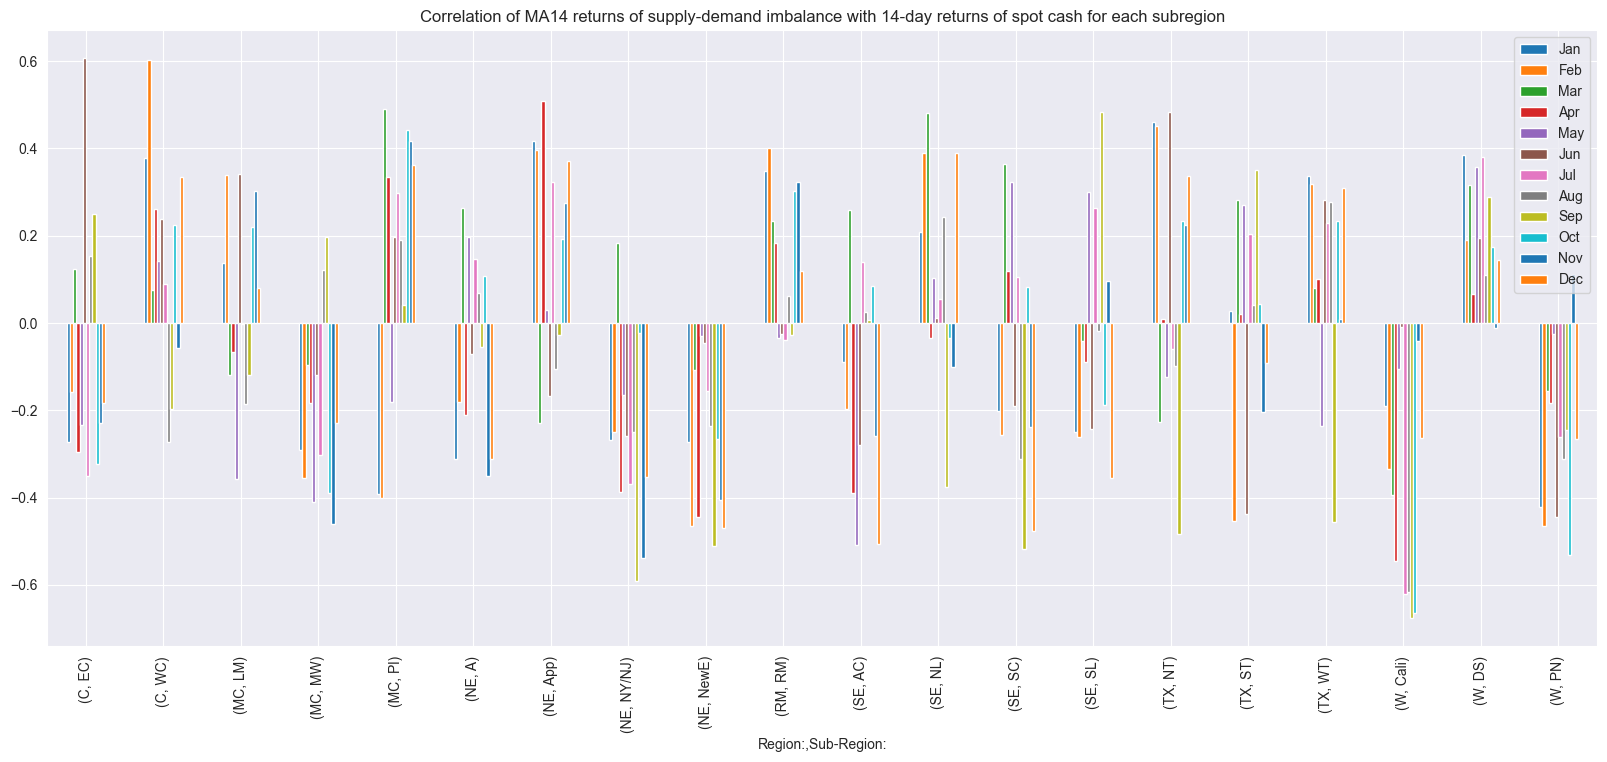

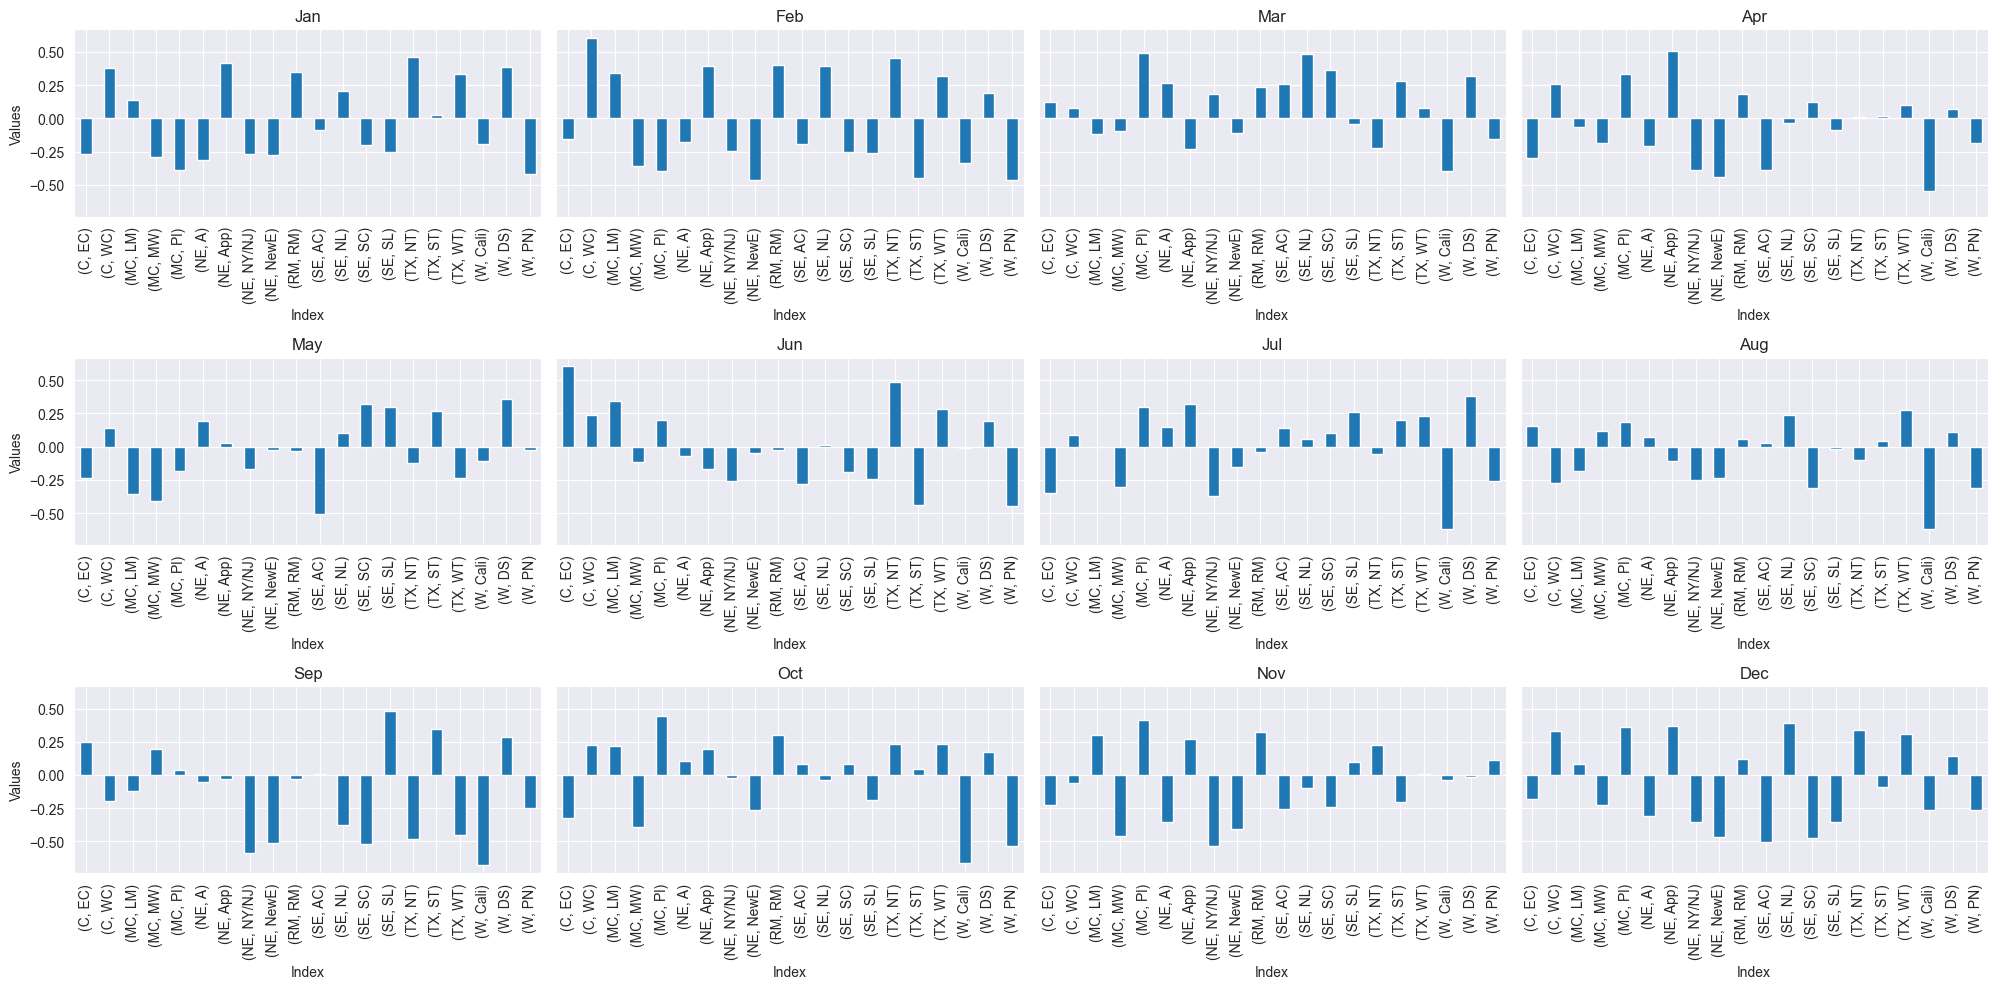

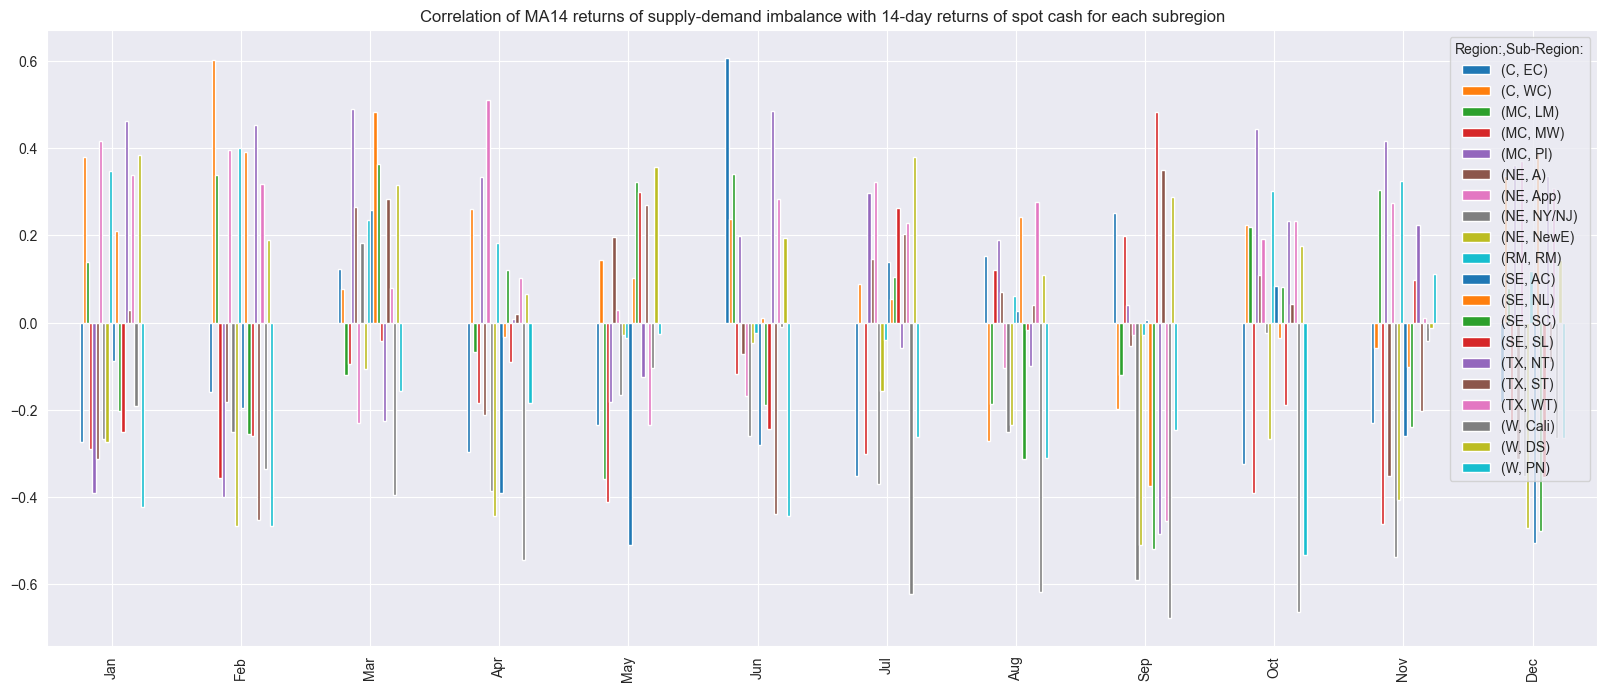

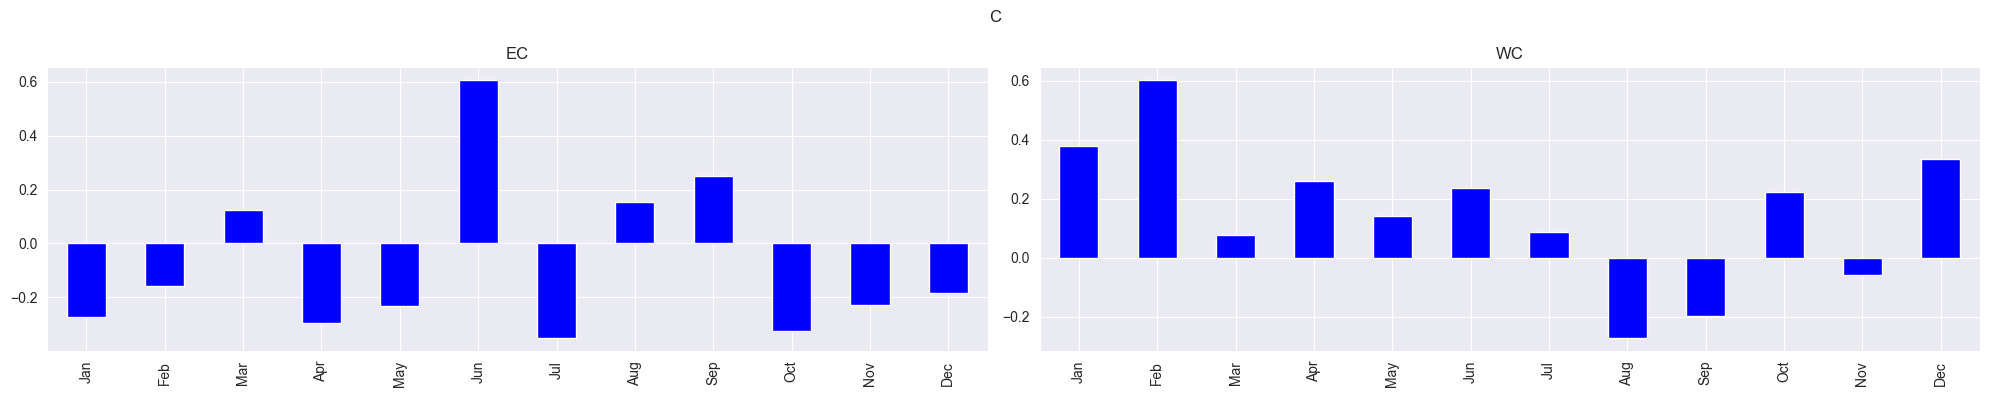

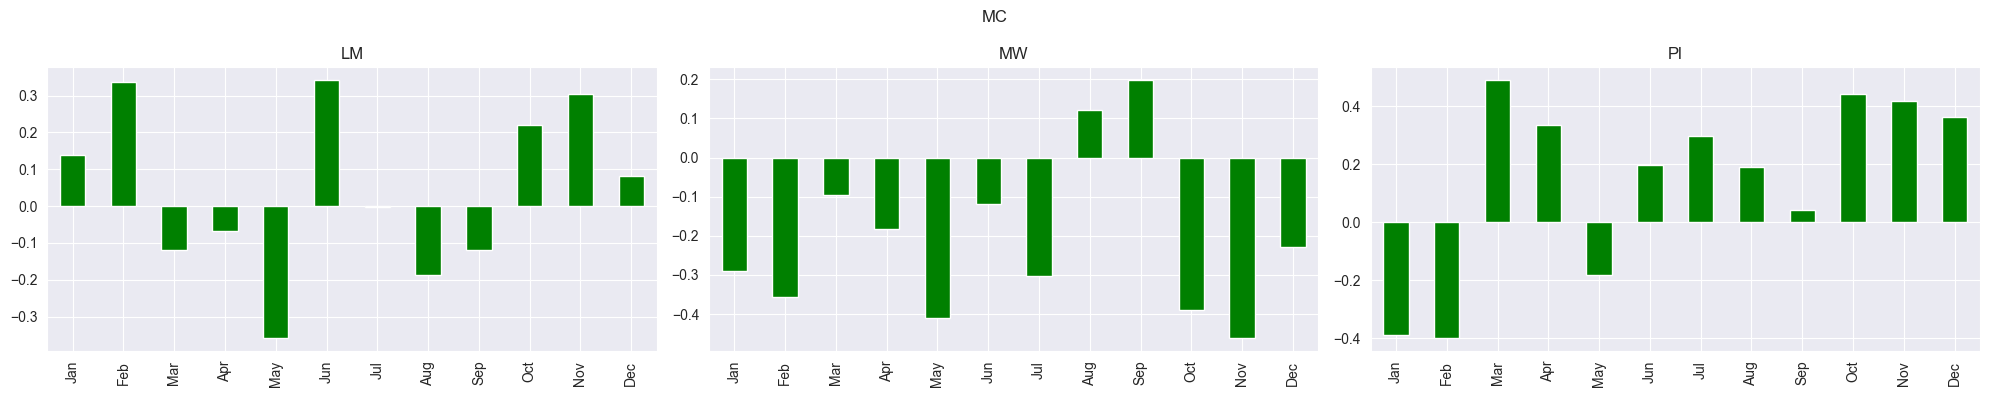

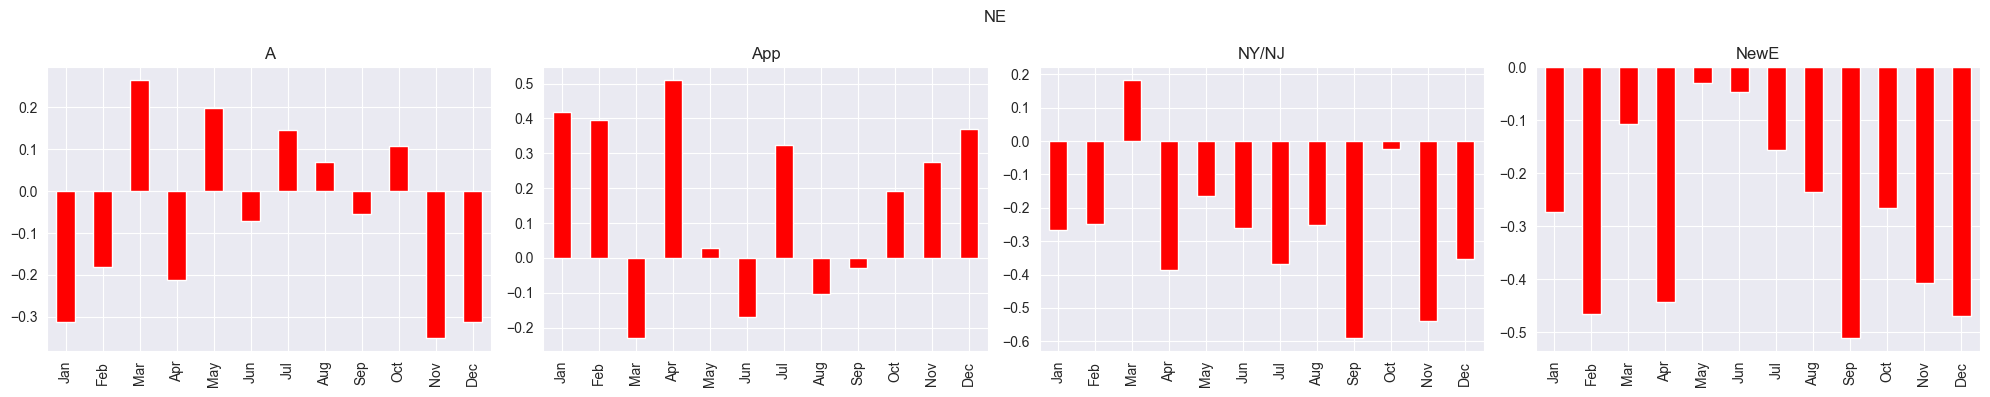

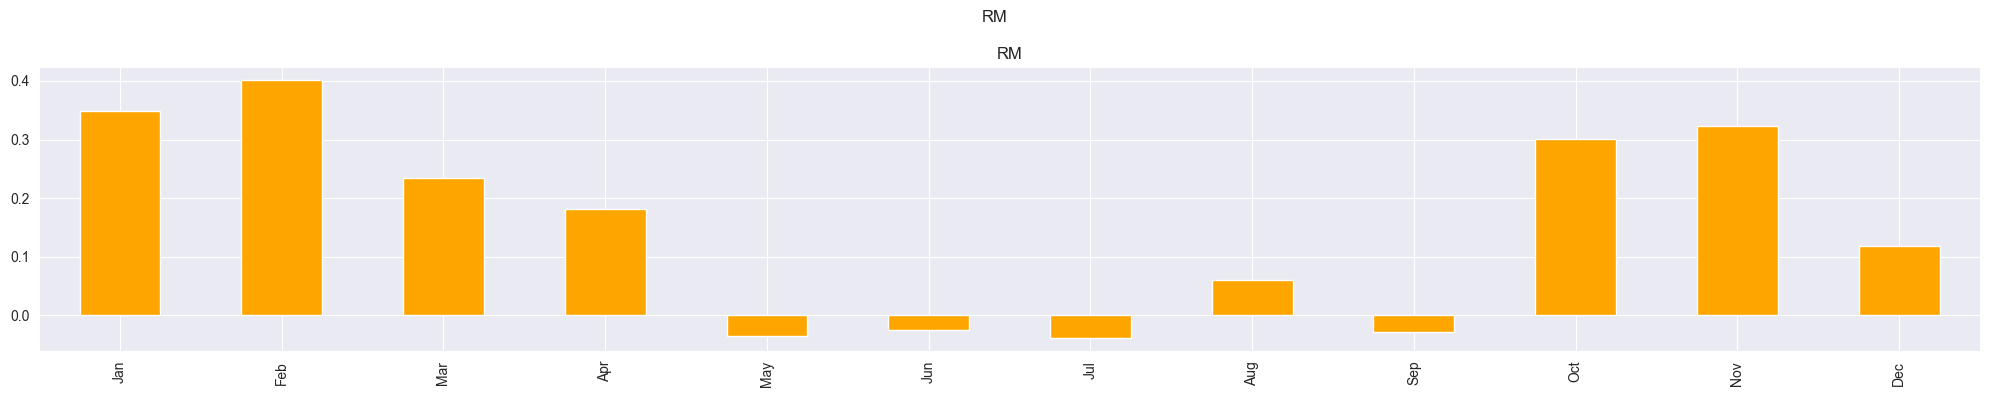

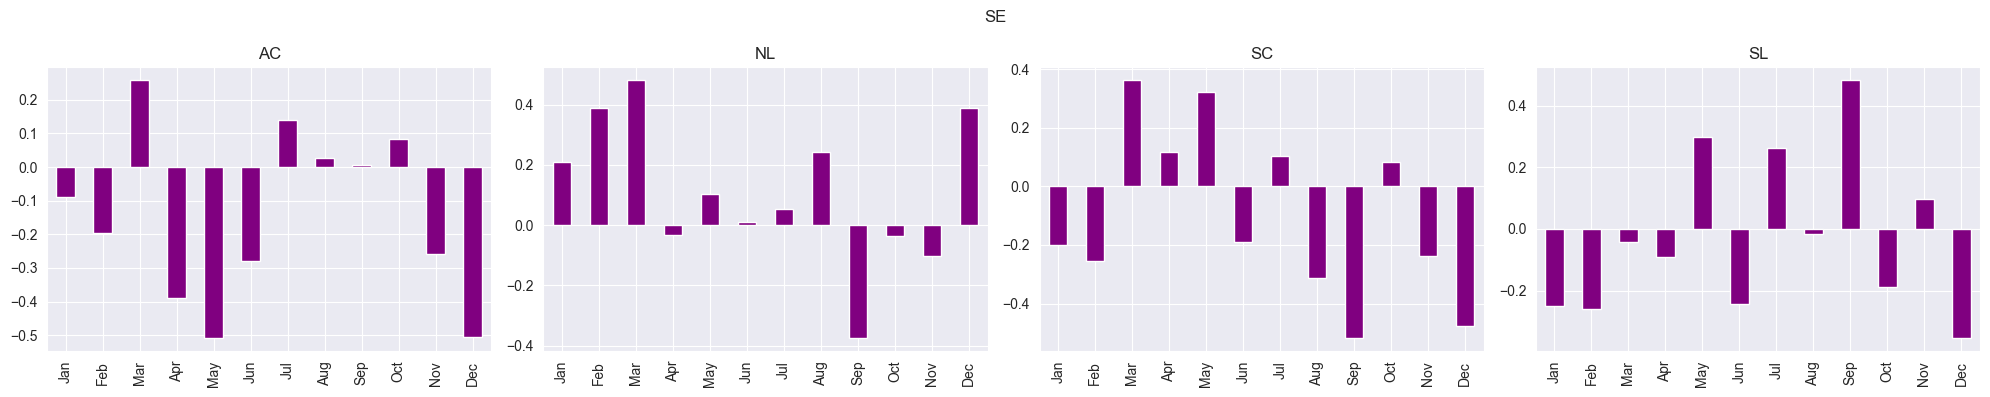

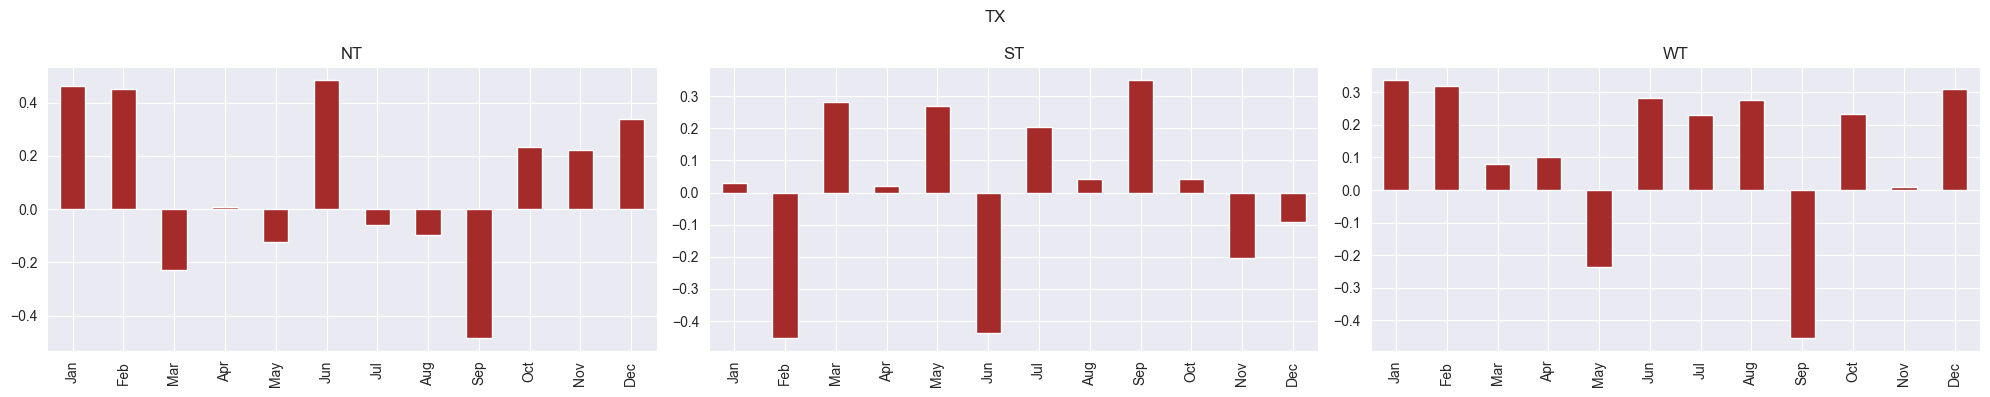

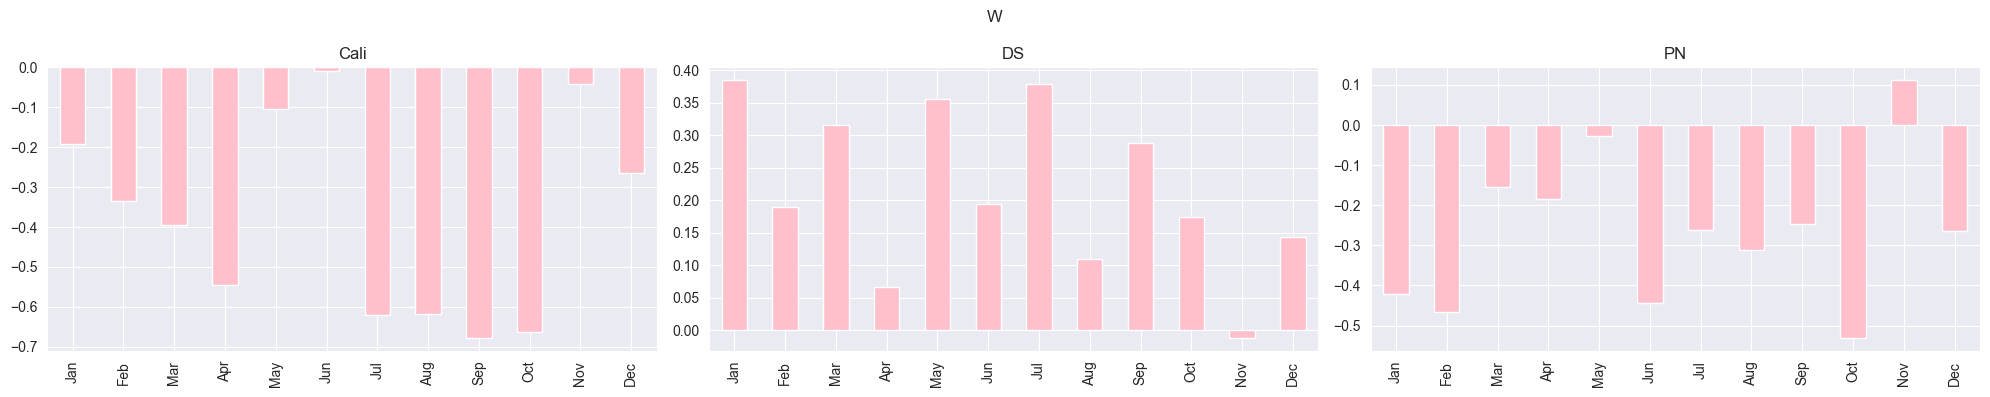

In [19]:
corrs = plotcorr(F,P, 14, 14, monthly=True)

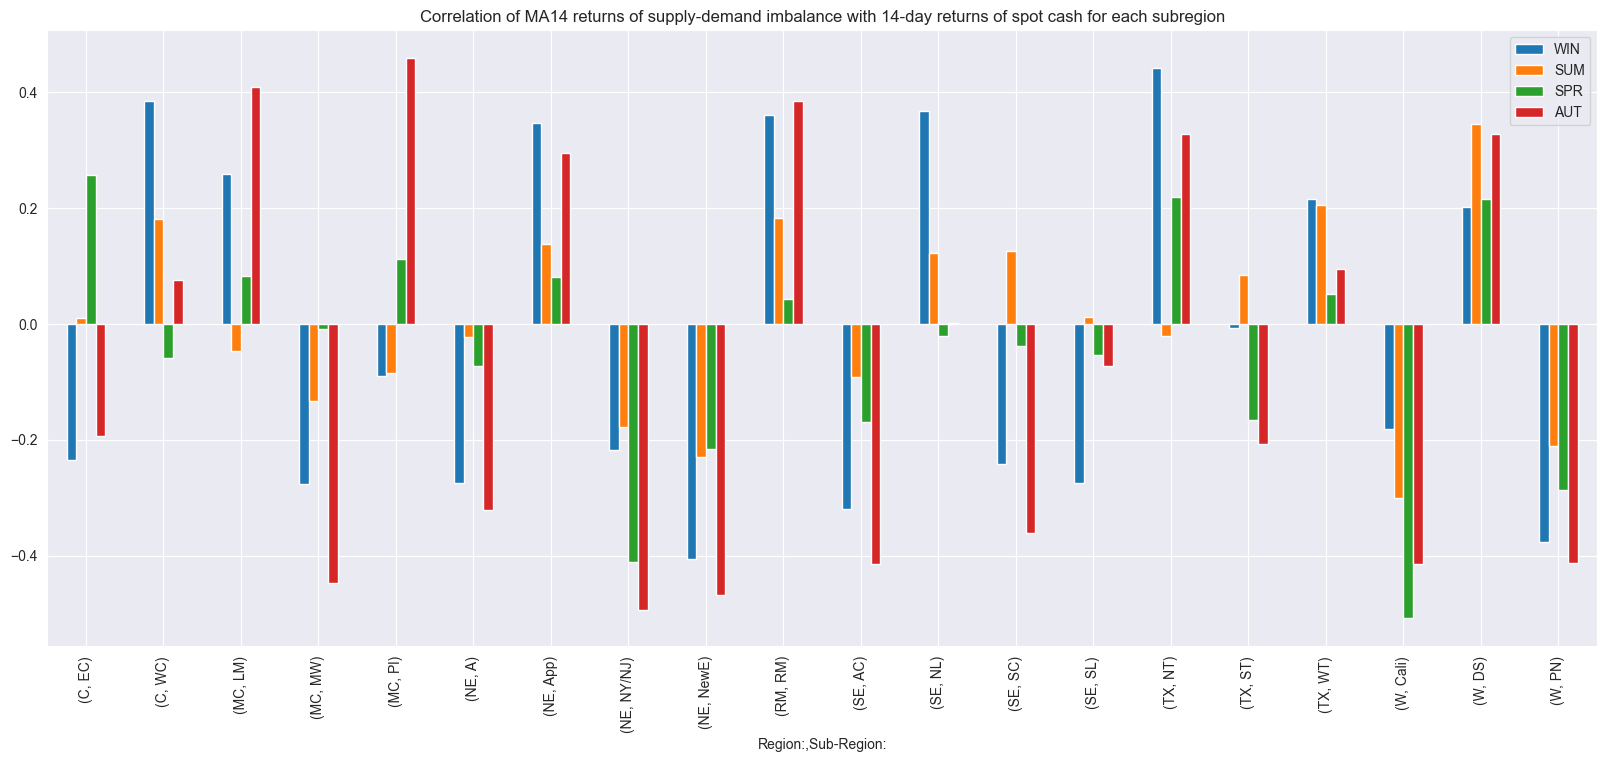

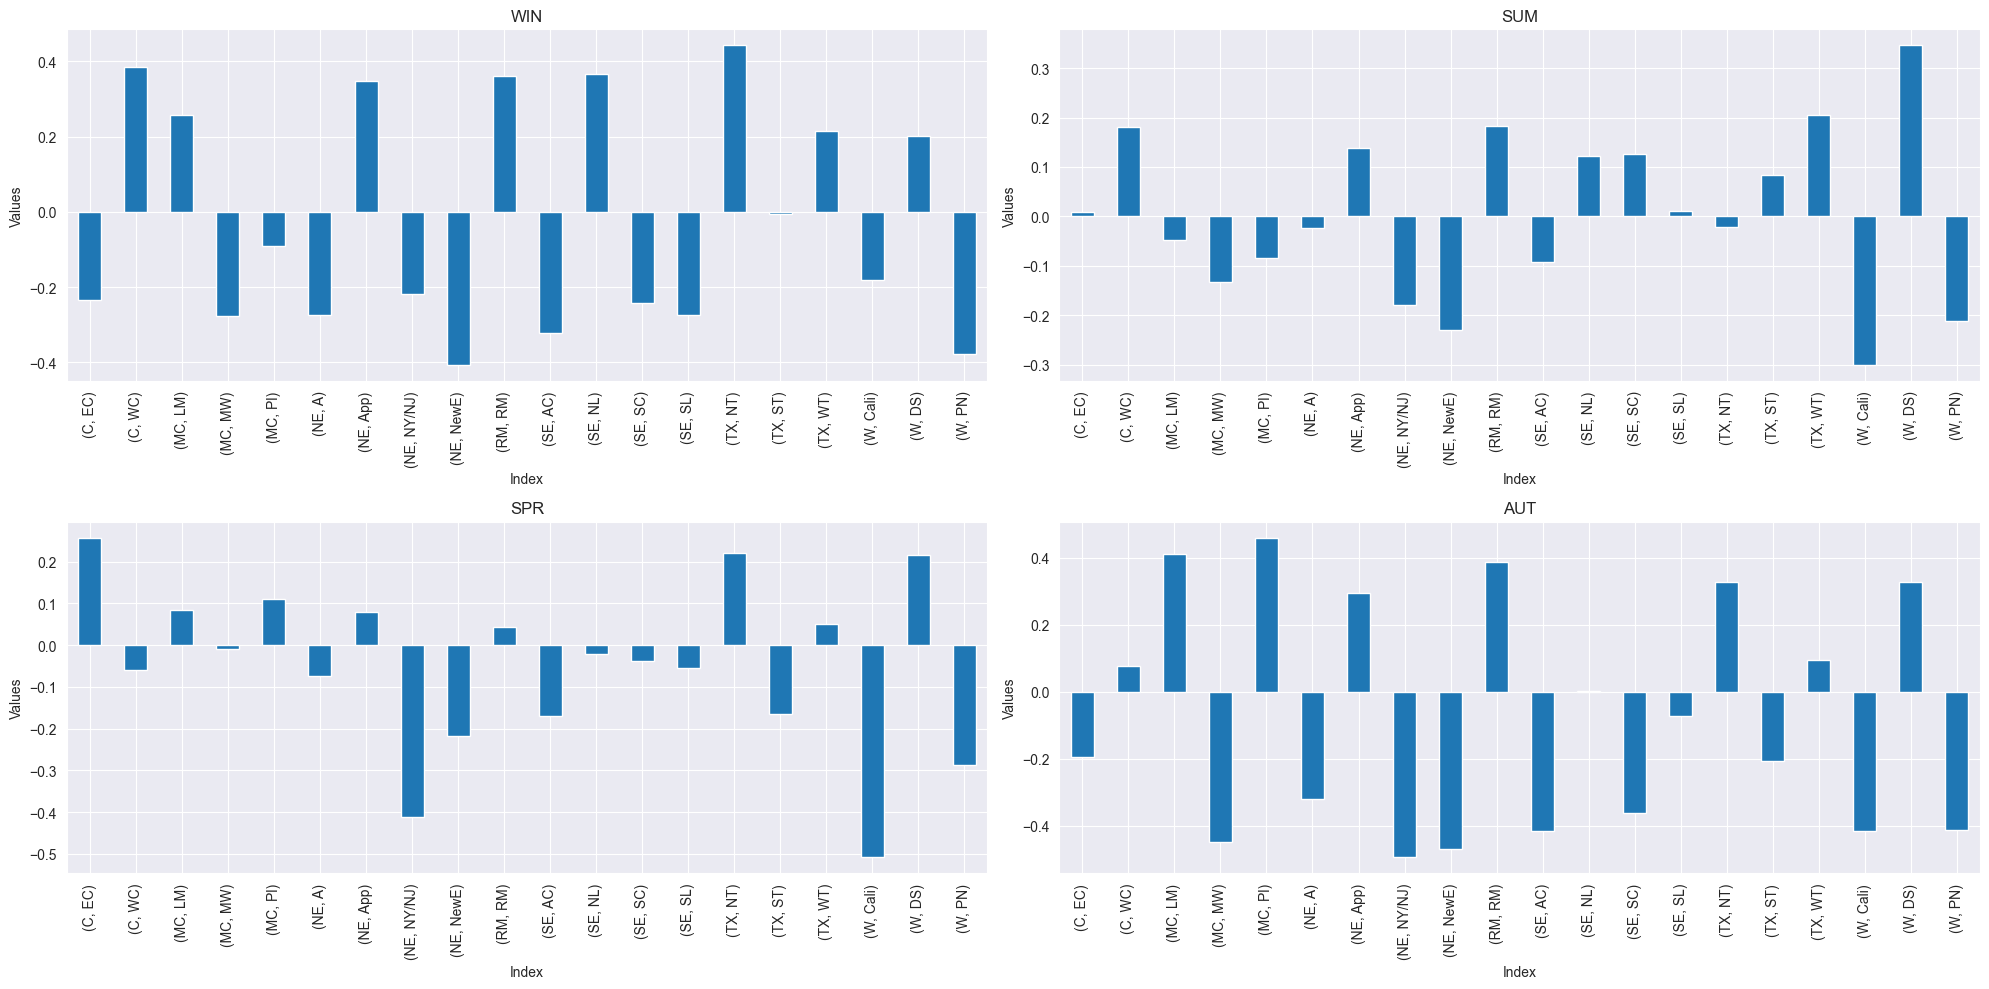

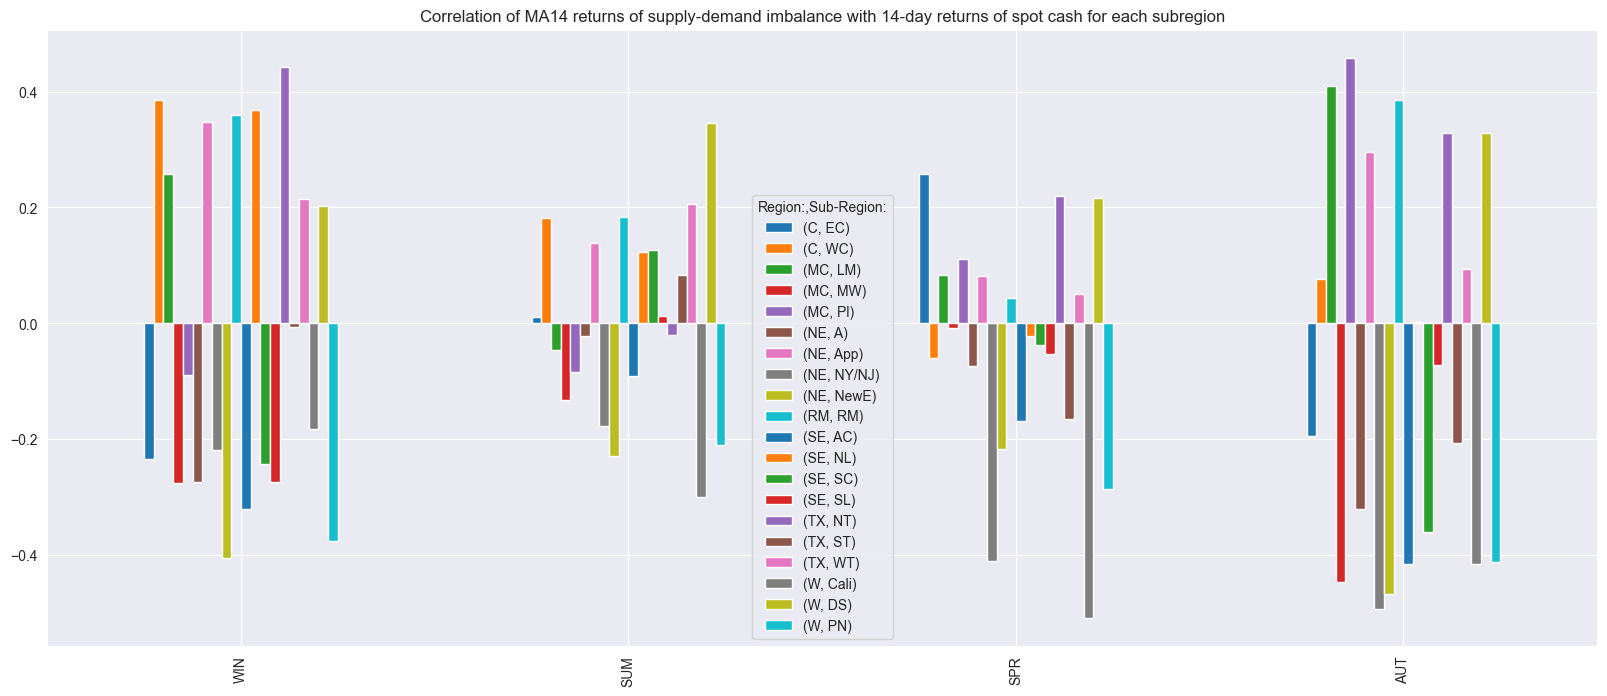

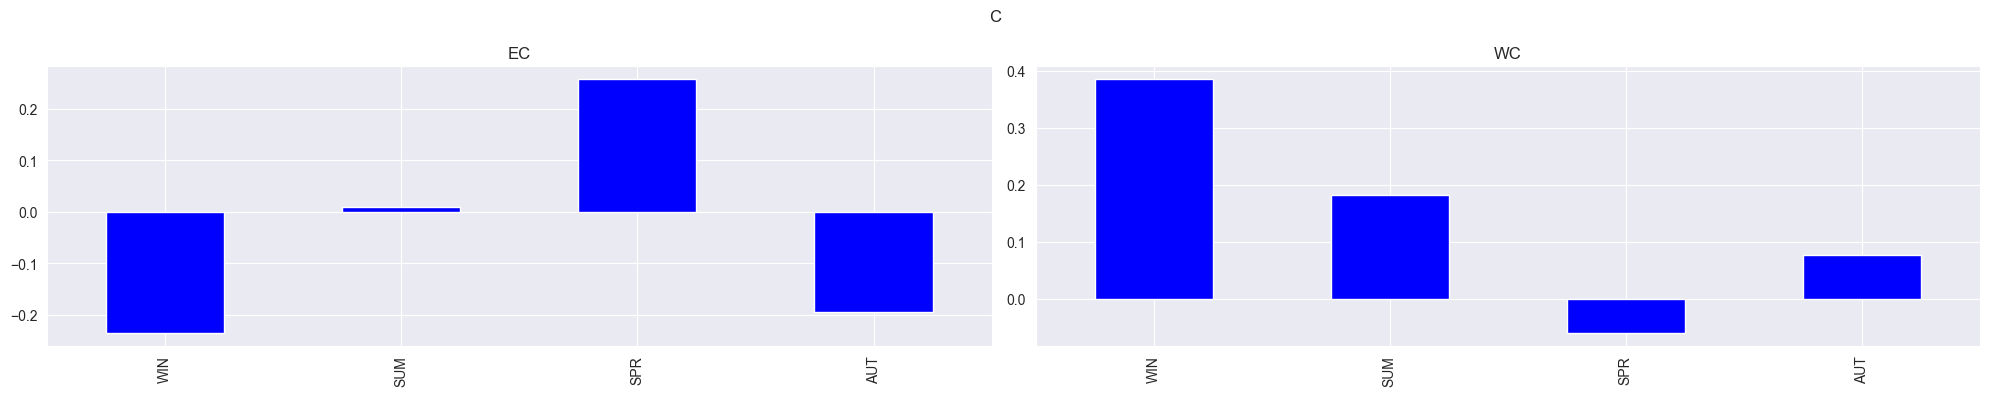

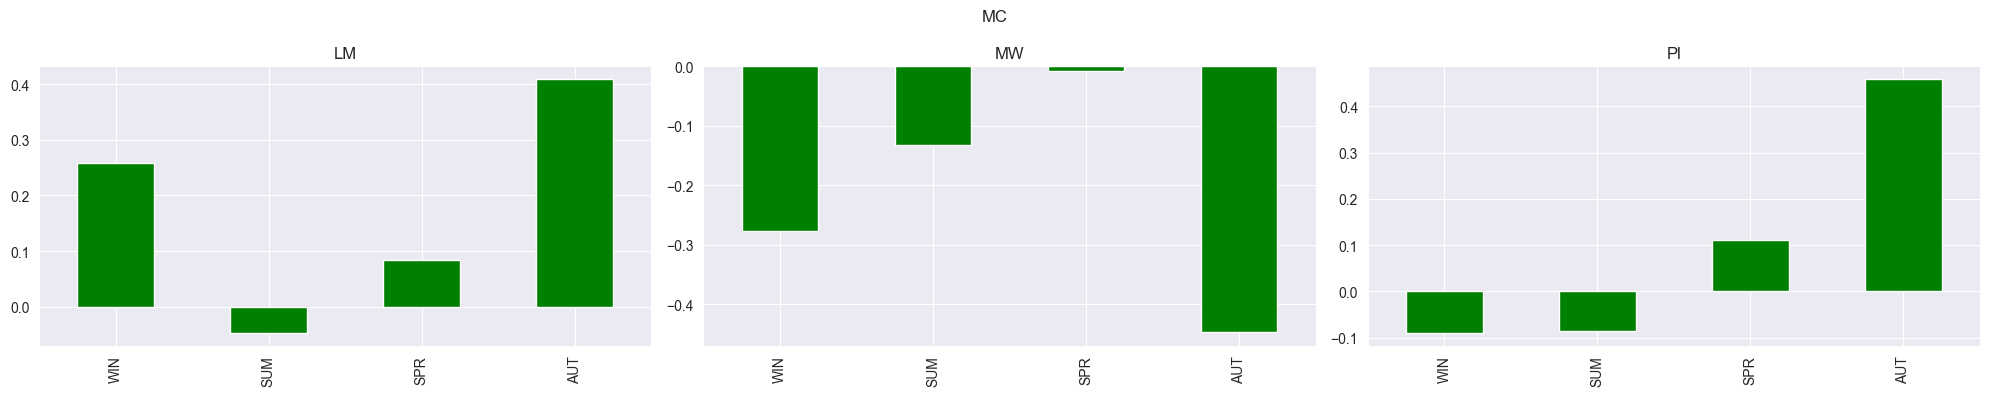

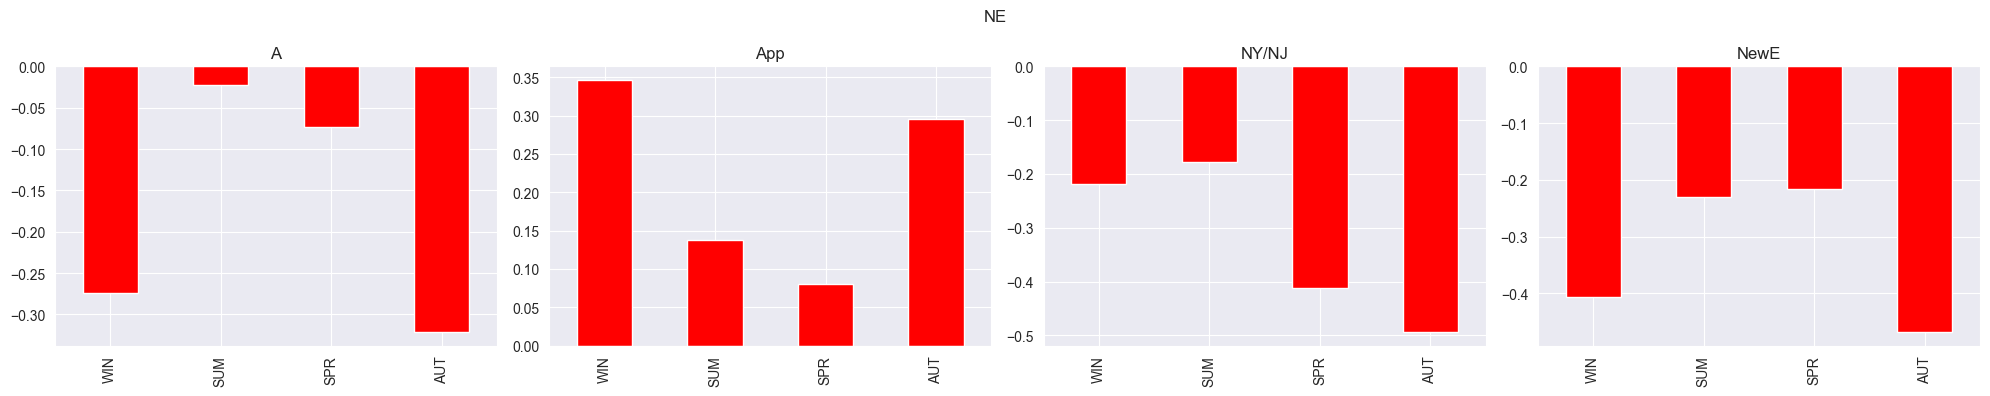

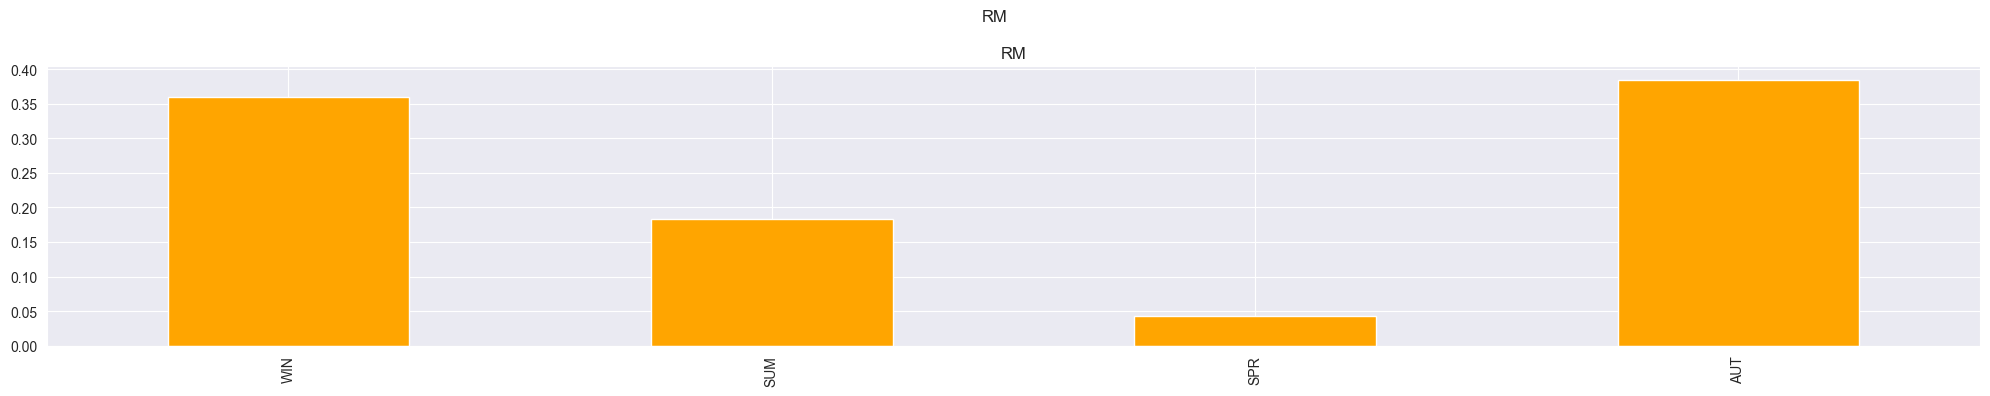

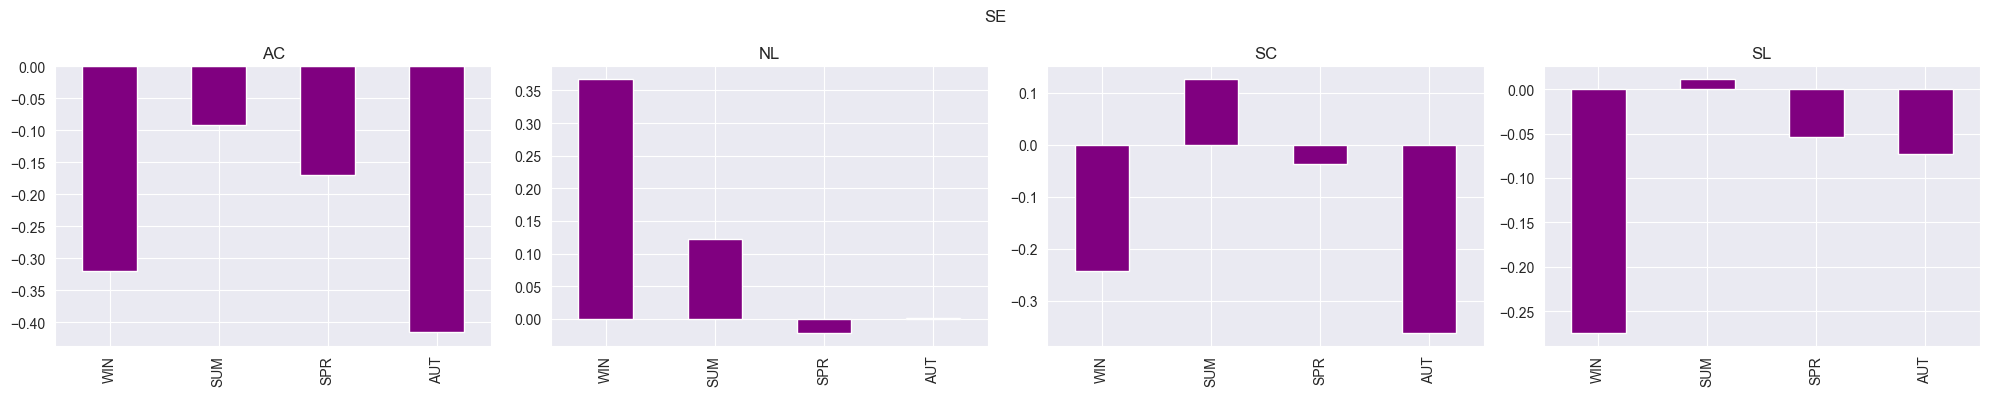

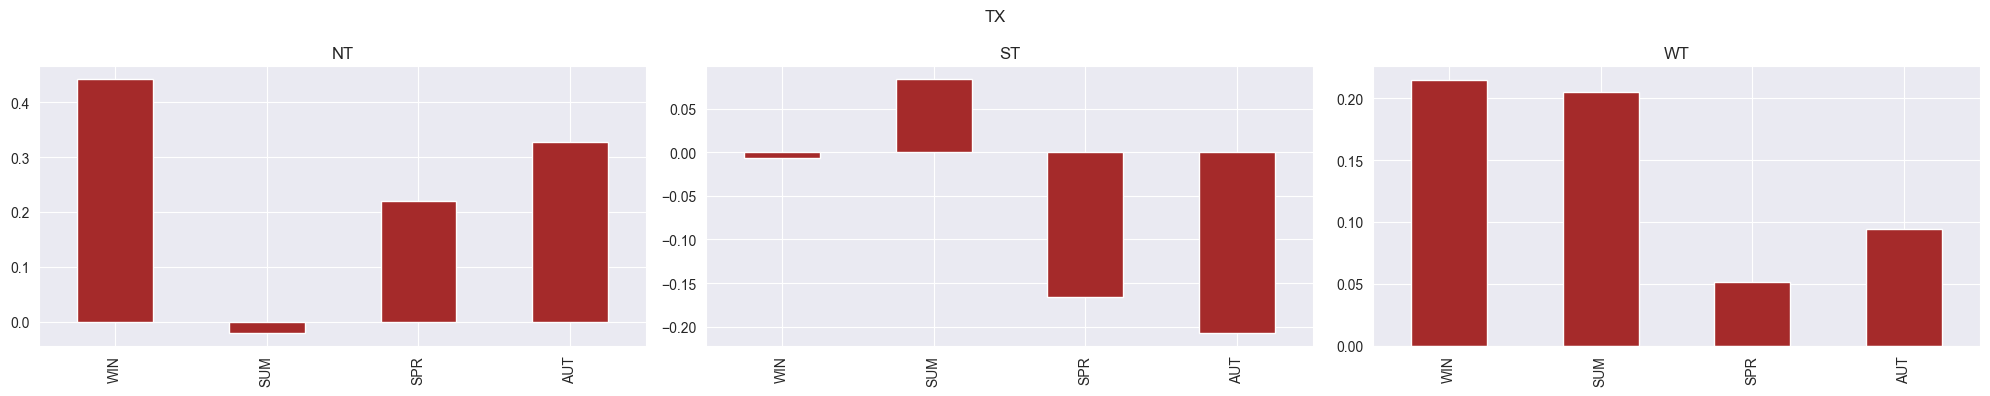

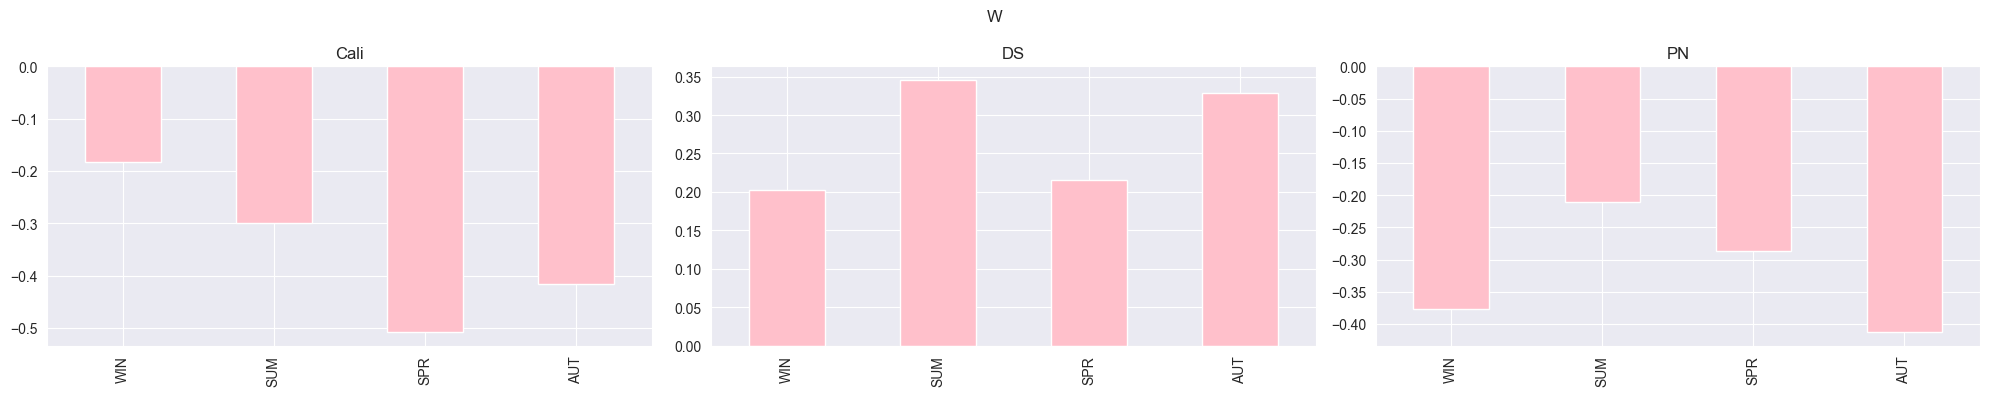

In [11]:
corrs = plotcorr(F,P, 14, 14, monthly=False)